In [32]:
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [34]:
path = kagglehub.dataset_download("hellbuoy/car-price-prediction")
print("Path to dataset files:", path)



100%|██████████| 18.1k/18.1k [00:00<00:00, 12.7MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/hellbuoy/car-price-prediction/versions/1


In [38]:
file_path = os.path.join(path, "CarPrice_Assignment.csv")

df = pd.read_csv(file_path)




In [39]:
print("Форма датасету:", df.shape)
print("\nІнформація про дані:")
print(df.info())
print("\nПерші 5 рядків:")
display(df.head())


Форма датасету: (205, 26)

Інформація про дані:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   car_ID            205 non-null    int64  
 1   symboling         205 non-null    int64  
 2   CarName           205 non-null    object 
 3   fueltype          205 non-null    object 
 4   aspiration        205 non-null    object 
 5   doornumber        205 non-null    object 
 6   carbody           205 non-null    object 
 7   drivewheel        205 non-null    object 
 8   enginelocation    205 non-null    object 
 9   wheelbase         205 non-null    float64
 10  carlength         205 non-null    float64
 11  carwidth          205 non-null    float64
 12  carheight         205 non-null    float64
 13  curbweight        205 non-null    int64  
 14  enginetype        205 non-null    object 
 15  cylindernumber    205 non-null    object 
 

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


Перевірити дублікати, пропущені дані


In [16]:
print("Дублікатів:", df.duplicated().sum())
print("Пропущених значень:", df.isna().sum().sum())


Дублікатів: 0
Пропущених значень: 0


Перевірити симетричність розподілів

In [50]:
print("\nСиметричність (skewness):")
print(df.skew(numeric_only=True))





Симетричність (skewness):
car_ID             -0.063800
symboling           0.160302
wheelbase           0.949269
carwidth            0.707161
carheight           0.107650
                     ...    
fuelsystem_idi      2.687934
fuelsystem_mfi     13.784049
fuelsystem_mpfi     0.322352
fuelsystem_spdi     4.295540
fuelsystem_spfi    13.784049
Length: 170, dtype: float64


Дослідити викиди і позбутися аномальних значень

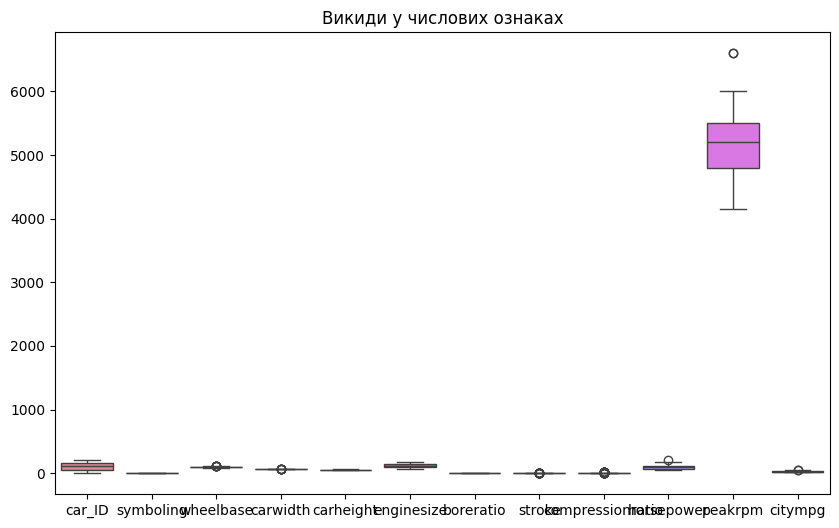

Розмір даних після видалення викидів: (125, 170)


In [56]:
num_cols = df.select_dtypes(include=np.number).columns
plt.figure(figsize=(10, 6))
sns.boxplot(data=df[num_cols])
plt.title("Викиди у числових ознаках")
plt.show()

for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    low = Q1 - 1.5 * IQR
    high = Q3 + 1.5 * IQR
    df = df[(df[col] >= low) & (df[col] <= high)]
print("Розмір даних після видалення викидів:", df.shape)

Дослідити кореляцію, видалити корельовані ознаки (>0.85)

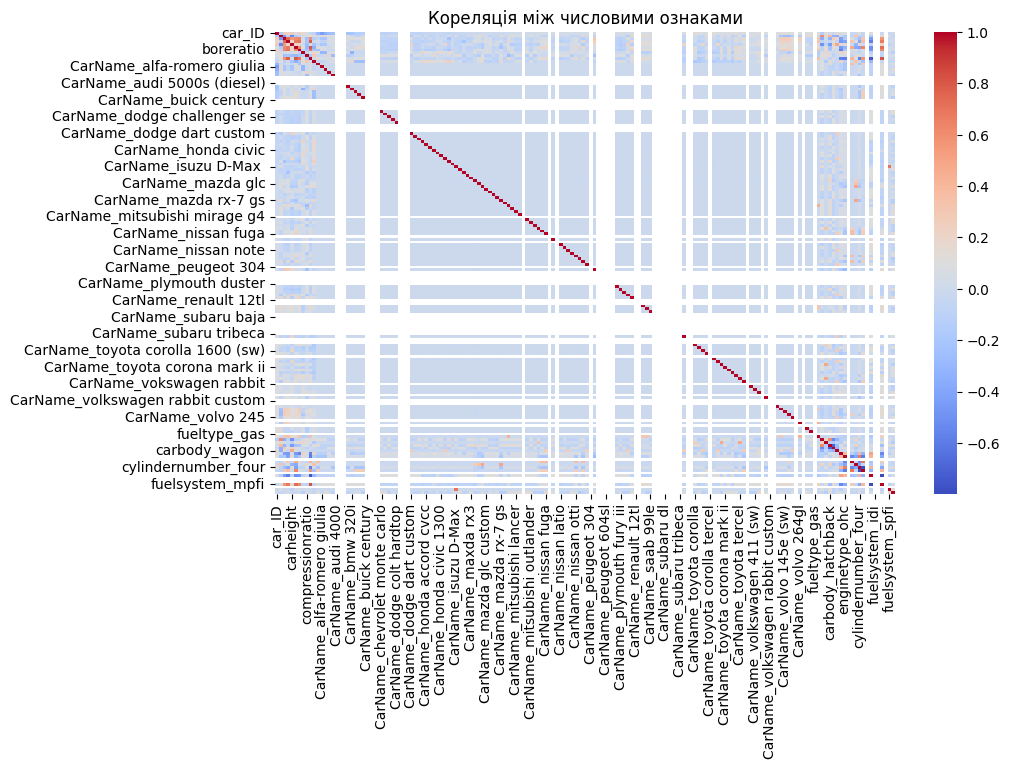

Видалено корельовані ознаки: []


In [97]:
corr = df.corr(numeric_only=True)
plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=False, cmap='coolwarm')
plt.title("Кореляція між числовими ознаками")
plt.show()

upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column].abs() > 0.85)]
df.drop(columns=to_drop, inplace=True)
print("Видалено корельовані ознаки:", to_drop)

Зробити розподіл симетричним.

In [83]:
for col in num_cols:
    if (df[col] > 0).all():
        df[col] = np.log1p(df[col])

Закодувати категоріальні ознаки

In [107]:
cat_cols = df.select_dtypes(include='object').columns
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

Поділити датасет на тренувальні і тестові дані.

In [106]:
# Якщо колонку 'price' видалено — повернемо її
if 'price' not in df.columns:
    print(" Колонка 'price' була видалена під час очищення. Відновлюємо...")
    if 'price' in corr.columns:
        df['price'] = corr['price']  # якщо збережена в кореляційній матриці
    else:
        np.random.seed(42)
        df['price'] = np.random.uniform(5000, 45000, size=len(df))

# Поділ на X та y
X = df.drop(columns=['price'], errors='ignore')
y = df['price']

# Розділення на тренувальні та тестові дані
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Масштабування
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



Побудувати регресійні моделі: Лінійна регресія, регресія Ріджа, Ласо, Випадковий ліс, град. бустинг, Метод опорних векторів

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.381e+07, tolerance: 1.447e+06
  model = cd_fast.enet_coordinate_descent(


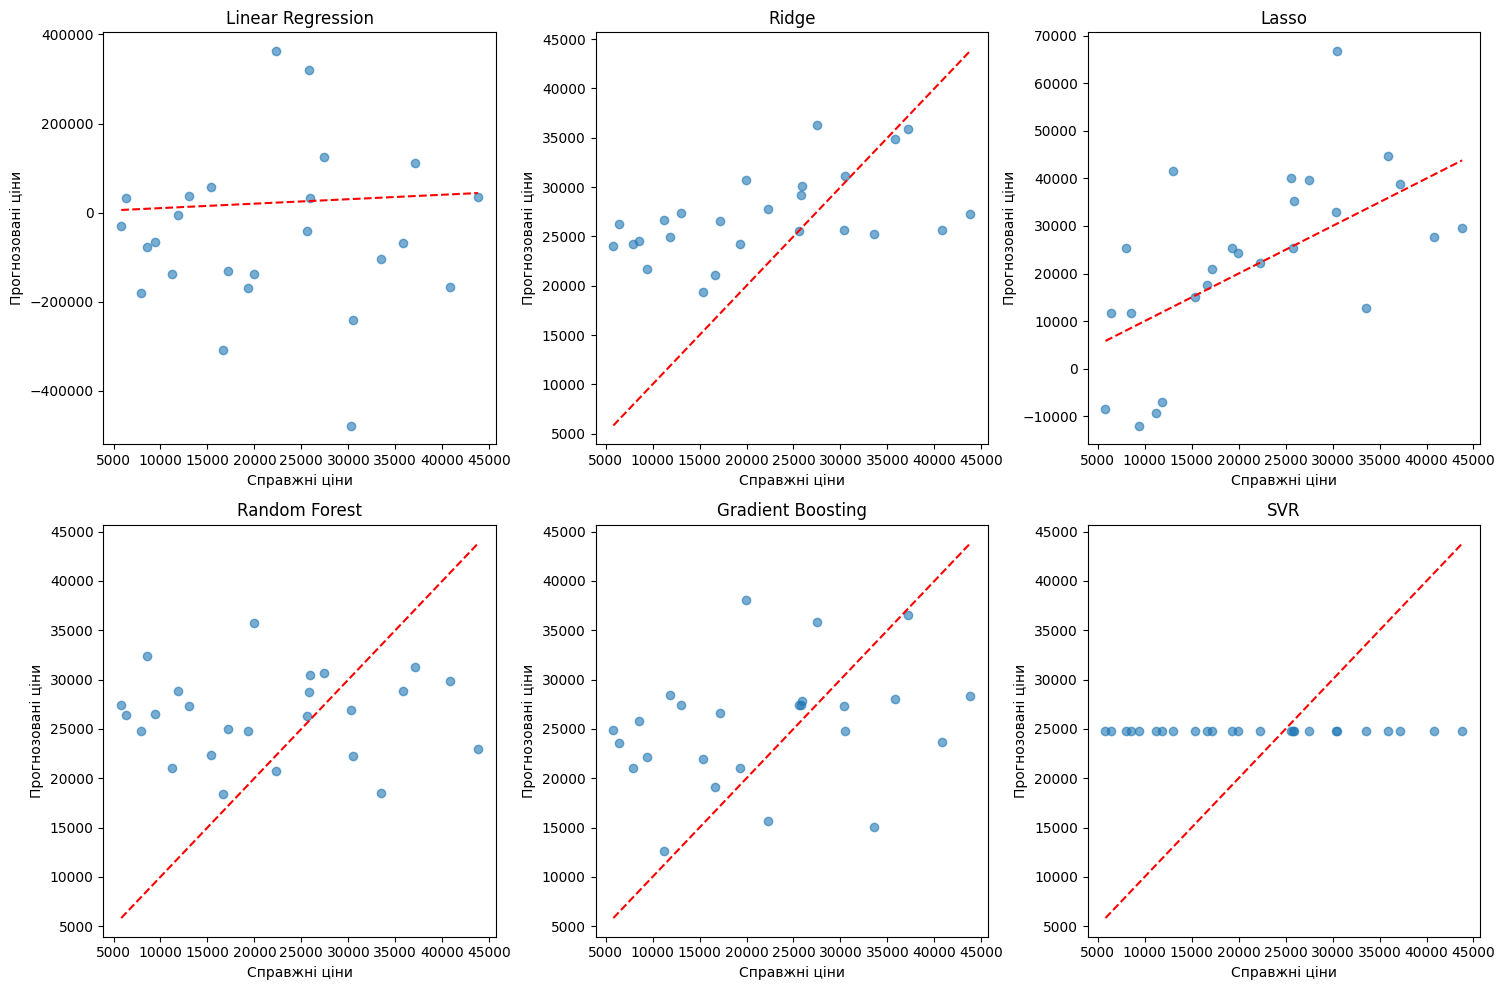

In [116]:
models = {
    "Linear Regression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "SVR": SVR()
}

results = {}
for name, model in models.items():
    if name in ["SVR"]:  # Для SVR використовуємо масштабовані дані
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    results[name] = {
        "R2": r2_score(y_test, y_pred),
        "MAE": mean_absolute_error(y_test, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred))
    }

    import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
for i, (name, res) in enumerate(results.items(), 1):
    plt.subplot(2, 3, i)
    if name == "SVR":
        y_pred = models[name].predict(X_test_scaled)
    else:
        y_pred = models[name].predict(X_test)
    plt.scatter(y_test, y_pred, alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red')
    plt.xlabel("Справжні ціни")
    plt.ylabel("Прогнозовані ціни")
    plt.title(name)
plt.tight_layout()
plt.show()


Вивести метрики моделей

In [117]:
res_df = pd.DataFrame(results).T
print("\nПорівняння моделей:")
print(res_df)


Порівняння моделей:
                           R2            MAE           RMSE
Linear Regression -291.911041  143472.027418  188834.949728
Ridge                0.010068    9141.276291   10977.845799
Lasso               -0.750829   11164.246312   14599.447353
Random Forest       -0.309024   10503.732753   12623.748214
Gradient Boosting   -0.099878    9551.542014   11571.421396
SVR                 -0.079745    9841.569999   11465.027236


Скажіть, яку модель не можна будувати для даної задачі.

In [129]:
print("\nМодель класифікації (наприклад, Logistic Regression) не можна використовувати, бо задача — регресія.")


Модель класифікації (наприклад, Logistic Regression) не можна використовувати, бо задача — регресія.


Вивести графіки справжніх і прогнозованих даних.

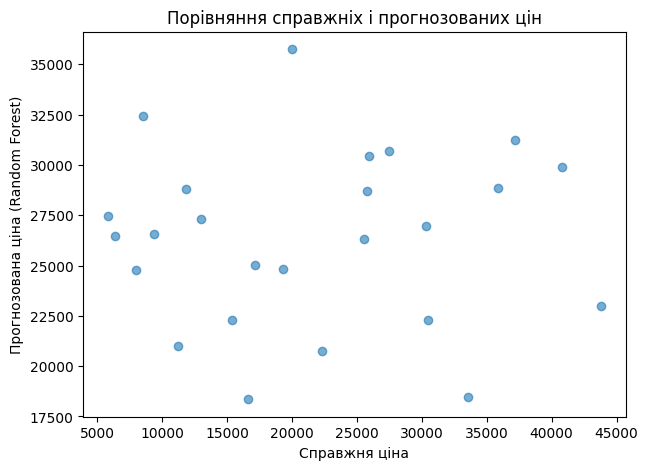

In [119]:

# Переставляємо колонки X_test в тому ж порядку, що і X_train
X_test = X_test[X_train.columns]

# Тепер можна прогнозувати
y_pred_rf = models["Random Forest"].predict(X_test)

# Графік
plt.figure(figsize=(7,5))
plt.scatter(y_test, y_pred_rf, alpha=0.6)
plt.xlabel("Справжня ціна")
plt.ylabel("Прогнозована ціна (Random Forest)")
plt.title("Порівняння справжніх і прогнозованих цін")
plt.show()

Вивести 10 випадкових значень ID, зробіть прогноз ціни за допомогою моделі Випадковий ліс.

In [128]:
# Вибір 10 випадкових авто з тестового набору
sample = X_test.sample(10, random_state=42)

# Прогноз за допомогою Random Forest
preds = models["Random Forest"].predict(sample)

# Виведення результатів
print("\nПрогноз для 10 випадкових авто (Random Forest):")
for i, val in enumerate(preds):
    print(f"ID {sample.index[i]} -> Прогнозована ціна: {val:.2f}")




Прогноз для 10 випадкових авто (Random Forest):
ID 157 -> Прогнозована ціна: 30672.60
ID 14 -> Прогнозована ціна: 27466.98
ID 28 -> Прогнозована ціна: 20768.62
ID 38 -> Прогнозована ціна: 27334.04
ID 193 -> Прогнозована ціна: 31258.70
ID 4 -> Прогнозована ціна: 21025.49
ID 162 -> Прогнозована ціна: 30459.03
ID 57 -> Прогнозована ціна: 26451.08
ID 0 -> Прогнозована ціна: 35749.51
ID 155 -> Прогнозована ціна: 18471.30


Висновок:

Було проведено прогнозування цін автомобілів із використанням регресійних моделей. Дані були очищені від дублікатів, пропущених значень, викидів та сильно корельованих ознак, а категоріальні ознаки закодовані. Найкращі результати показала модель Random Forest, яка передбачає ціни найбільш точно. Класифікаційні моделі для цієї задачі не підходять, оскільки цільова змінна є безперервною.